In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import schedules, SGD
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import time


2022-11-16 23:16:51.837554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tifffile as tiff

In [4]:
batch_size = 256
img_height = 8
img_width = 8
data_dir = 'sw_se/data2'

In [173]:
def augment(x, y):
    image = tf.image.random_brightness(x, max_delta=0.05)
    return image, y

# ds_train = ds_train.map(augment)
    

### data transform

In [7]:
import os
def read_data(directory):
    X = []
    y = []
    for species in os.listdir(directory):
        print(species)
        if not species.startswith('.'):
            for i in os.listdir(directory + '/' + species):
                if not i.startswith('.'):
                    f = os.path.join(directory, species, i)
                    img = tiff.imread(f)
                    b0 = img[0]
                    b1 = img[1]
                    b2 = img[2]
                    b3 = img[3]
                    arr = np.stack((b0, b1, b2, b3), axis=2)
                    label = species
                    X.append(arr)
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    print(X.shape, y.shape)
    return X, y

X, y = read_data('sw_se/data2')

ashe
southern
elm
pecan
hackberry
escarpment
crape
(37458, 8, 8, 4) (37458,)


AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [9]:
species_dict = {'pecan': 0,
                'elm': 1,
                'southern': 2,
                'escarpment': 3,
                'crape': 4,
                'hackberry': 5,
                'ashe': 6}
y = np.vectorize(species_dict.get)(y)

In [146]:
from sklearn.model_selection import train_test_split
X = X / 255.
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, stratify = y_dev, random_state=42)

In [147]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(23972, 8, 8, 4) (23972,)
(5994, 8, 8, 4) (5994,)
(7492, 8, 8, 4) (7492,)


In [148]:
y_train_oh = keras.utils.to_categorical(y_train, 7)
y_val_oh = keras.utils.to_categorical(y_val, 7)
y_test_oh = keras.utils.to_categorical(y_test, 7)

In [29]:
def preprocessed_dataset(X_train, y_train, X_test, y_test):
    """
        Load and preprocess dataset.
    """
    (input_train, target_train), (input_test, target_test) = (X_train, y_train), (X_test, y_test)

    # Retrieve shape from model configuration and unpack into components
    width, height, dim = 8, 8, 4
    num_classes = 7
    batch_size=256

#     # Convert scalar targets to categorical ones
    target_train = keras.utils.to_categorical(target_train, num_classes)
    target_test = keras.utils.to_categorical(target_test, num_classes)

    # Data generator for training data
    train_generator = keras.preprocessing.image.ImageDataGenerator(
        validation_split = 0.1,
#         horizontal_flip = True,
        rescale = 1./255,
#         preprocessing_function = keras.applications.resnet50.preprocess_input
    )

    # Generate training and validation batches
    train_batches = train_generator.flow(input_train, target_train, batch_size=batch_size, subset="training")
    validation_batches = train_generator.flow(input_train, target_train, batch_size=batch_size, subset="validation")

    # Data generator for testing data
    test_generator = keras.preprocessing.image.ImageDataGenerator(
#         preprocessing_function = keras.applications.resnet50.preprocess_input,
        rescale = 1./255)

    # Generate test batches
    test_batches = test_generator.flow(input_test, target_test, batch_size=batch_size)

    return train_batches, validation_batches, test_batches

In [30]:
train_batches, validation_batches, test_batches = preprocessed_dataset(X_train, y_train, X_test, y_test)

## ResNet34

In [13]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [17]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [60]:
def ResNet34(shape = (8, 8, 4), classes = 7, filter_size=16):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(filter_size, kernel_size=7, strides=2, padding='same')(x)   # 64
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]

    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [61]:
def create_ResNet34(filter_size=16):
    model = ResNet34(filter_size=filter_size)
    boundaries = [32000, 48000]
    values = [0.1, 0.01, 0.001]
    lr_schedule = schedules.PiecewiseConstantDecay(boundaries, values)
    optimizer_momentum = 0.9


    model.compile(optimizer = SGD(learning_rate=lr_schedule, momentum=optimizer_momentum),
                  metrics = ["accuracy"],
                  loss = keras.losses.CategoricalCrossentropy())
    return model

In [38]:
res34_1 = create_ResNet34()

In [34]:
res34_1.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 8, 4)]    0           []                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 14, 14, 4)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 7, 7, 16)     3152        ['zero_padding2d_3[0][0]']       
                                                                                                  
 batch_normalization_75 (BatchN  (None, 7, 7, 16)    64          ['conv2d_81[0][0]']       

                                                                  'conv2d_90[0][0]']              
                                                                                                  
 activation_82 (Activation)     (None, 2, 2, 32)     0           ['add_39[0][0]']                 
                                                                                                  
 conv2d_91 (Conv2D)             (None, 2, 2, 32)     9248        ['activation_82[0][0]']          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 2, 2, 32)    128         ['conv2d_91[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_83 (Activation)     (None, 2, 2, 32)     0           ['batch_normalization_84[0][0]'] 
          

 batch_normalization_93 (BatchN  (None, 1, 1, 64)    256         ['conv2d_101[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 add_44 (Add)                   (None, 1, 1, 64)     0           ['batch_normalization_93[0][0]', 
                                                                  'activation_90[0][0]']          
                                                                                                  
 activation_92 (Activation)     (None, 1, 1, 64)     0           ['add_44[0][0]']                 
                                                                                                  
 conv2d_102 (Conv2D)            (None, 1, 1, 64)     36928       ['activation_92[0][0]']          
                                                                                                  
 batch_nor

 conv2d_111 (Conv2D)            (None, 1, 1, 128)    147584      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_103 (Batch  (None, 1, 1, 128)   512         ['conv2d_111[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_112 (Conv2D)            (None, 1, 1, 128)    8320        ['activation_100[0][0]']         
                                                                                                  
 add_49 (Add)                   (None, 1, 1, 128)    0           ['batch_normalization_103[0][0]',
                                                                  'conv2d_112[0][0]']             
                                                                                                  
 activatio

In [46]:
# Load Tensorboard callback
tensorboard = tf.keras.callbacks.TensorBoard(
  log_dir=os.path.join(os.getcwd(), "logs"),
  histogram_freq=1,
  write_images=True
)

checkpoint_path = os.path.join(os.getcwd(), "model_checkpoint")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save a model checkpoint after every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_path,
    save_best_only=True,
    save_weights_only=True,
#     save_freq="epoch"
)

# Add callbacks to list
callbacks = [
  tensorboard,
  checkpoint
]

In [149]:
hist = res34_1.fit(x=X_train, y=y_train_oh, 
            batch_size=256,
            epochs=5, 
            validation_data=(X_val, y_val_oh),
            callbacks=callbacks,
            verbose=1)

Epoch 1/5
94/94 [==============================] - 12s 122ms/step - loss: 1.5318 - accuracy: 0.4107 - val_loss: 1.8737 - val_accuracy: 0.2217
Epoch 2/5
94/94 [==============================] - 12s 124ms/step - loss: 1.4713 - accuracy: 0.4373 - val_loss: 1.9657 - val_accuracy: 0.2217
Epoch 3/5
94/94 [==============================] - 10s 108ms/step - loss: 1.4542 - accuracy: 0.4427 - val_loss: 2.2203 - val_accuracy: 0.2217
Epoch 4/5
94/94 [==============================] - 10s 108ms/step - loss: 1.4427 - accuracy: 0.4481 - val_loss: 3.2395 - val_accuracy: 0.2217
Epoch 5/5
94/94 [==============================] - 10s 108ms/step - loss: 1.4383 - accuracy: 0.4504 - val_loss: 2.7002 - val_accuracy: 0.2217


In [150]:
score = res34_1.evaluate(test_batches, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.8128876686096191 / Test accuracy: 0.21663106977939606


In [151]:
score = res34_1.evaluate(X_test, y_test_oh, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 2.6982429027557373 / Test accuracy: 0.22156967222690582


In [160]:
score = res34_1.evaluate(X_train, y_train_oh, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 2.693744659423828 / Test accuracy: 0.22167529165744781


In [156]:
score = res34_1.evaluate(X_val, y_val_oh, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 2.7002112865448 / Test accuracy: 0.22172172367572784


In [162]:
y_train_pred = res34_1.predict(X_train)

750/750 [==============================] - 8s 11ms/step


In [163]:
y_train_pred[:10,]

array([[0.07542554, 0.67837334, 0.04082103, 0.03527438, 0.01192324,
        0.06625334, 0.09192911],
       [0.03172899, 0.6902676 , 0.04455728, 0.03201417, 0.00771014,
        0.05859273, 0.13512911],
       [0.06708337, 0.6944859 , 0.03760284, 0.02982701, 0.01127694,
        0.06724896, 0.09247499],
       [0.02320475, 0.6774258 , 0.04408096, 0.02877177, 0.0069256 ,
        0.059141  , 0.16045013],
       [0.02653006, 0.6527226 , 0.05211006, 0.03666857, 0.00740211,
        0.05871512, 0.1658515 ],
       [0.03347626, 0.68993455, 0.044092  , 0.03184778, 0.00794001,
        0.06036552, 0.13234387],
       [0.01948122, 0.66442436, 0.04867168, 0.03126801, 0.00637554,
        0.05277985, 0.1769994 ],
       [0.05668864, 0.69474095, 0.04071924, 0.03281469, 0.0100523 ,
        0.06391519, 0.10106895],
       [0.03704762, 0.69657195, 0.04214463, 0.03105917, 0.00831185,
        0.06052982, 0.12433492],
       [0.08999822, 0.7062787 , 0.03119765, 0.02351025, 0.0128209 ,
        0.06824243, 0.0

array([ True,  True,  True, ...,  True,  True,  True])

In [50]:
print(checkpoint_path)

/Users/ziyanliu/Desktop/Capstone/model_checkpoint


In [51]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/Users/ziyanliu/Desktop/Capstone/model_checkpoint'

In [43]:
res34_2 = create_ResNet34()
score = res34_2.evaluate(test_batches, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.9450786113739014 / Test accuracy: 0.1863320916891098


In [52]:
res34_2.load_weights(latest)
score = res34_2.evaluate(test_batches, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.5300594568252563 / Test accuracy: 0.40496528148651123


In [125]:
res34_3 = create_ResNet34(filter_size=16)

In [64]:
# res34_3.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 8, 8, 4)]    0           []                               
                                                                                                  
 zero_padding2d_7 (ZeroPadding2  (None, 14, 14, 4)   0           ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_192 (Conv2D)            (None, 7, 7, 64)     12608       ['zero_padding2d_7[0][0]']       
                                                                                                  
 batch_normalization_177 (Batch  (None, 7, 7, 64)    256         ['conv2d_192[0][0]']      

                                                                  'conv2d_201[0][0]']             
                                                                                                  
 activation_183 (Activation)    (None, 2, 2, 128)    0           ['add_88[0][0]']                 
                                                                                                  
 conv2d_202 (Conv2D)            (None, 2, 2, 128)    147584      ['activation_183[0][0]']         
                                                                                                  
 batch_normalization_186 (Batch  (None, 2, 2, 128)   512         ['conv2d_202[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_184 (Activation)    (None, 2, 2, 128)    0           ['batch_normalization_186[0][0]']
          

 batch_normalization_195 (Batch  (None, 1, 1, 256)   1024        ['conv2d_212[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_93 (Add)                   (None, 1, 1, 256)    0           ['batch_normalization_195[0][0]',
                                                                  'activation_191[0][0]']         
                                                                                                  
 activation_193 (Activation)    (None, 1, 1, 256)    0           ['add_93[0][0]']                 
                                                                                                  
 conv2d_213 (Conv2D)            (None, 1, 1, 256)    590080      ['activation_193[0][0]']         
                                                                                                  
 batch_nor

 conv2d_222 (Conv2D)            (None, 1, 1, 512)    2359808     ['activation_202[0][0]']         
                                                                                                  
 batch_normalization_205 (Batch  (None, 1, 1, 512)   2048        ['conv2d_222[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_223 (Conv2D)            (None, 1, 1, 512)    131584      ['activation_201[0][0]']         
                                                                                                  
 add_98 (Add)                   (None, 1, 1, 512)    0           ['batch_normalization_205[0][0]',
                                                                  'conv2d_223[0][0]']             
                                                                                                  
 activatio

In [168]:
model3_hist = res34_3.fit(x=X_train, y=y_train_oh, 
                          batch_size=256,
                          epochs=50, 
                          validation_data=(X_val, y_val_oh),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
94/94 [==============================] - 11s 111ms/step - loss: 1.5774 - accuracy: 0.3912 - val_loss: 1.8544 - val_accuracy: 0.2716
Epoch 2/50
94/94 [==============================] - 10s 108ms/step - loss: 1.5009 - accuracy: 0.4313 - val_loss: 1.8107 - val_accuracy: 0.2716
Epoch 3/50
94/94 [==============================] - 10s 108ms/step - loss: 1.4782 - accuracy: 0.4396 - val_loss: 1.8956 - val_accuracy: 0.2766
Epoch 4/50
94/94 [==============================] - 10s 109ms/step - loss: 1.4681 - accuracy: 0.4424 - val_loss: 1.9414 - val_accuracy: 0.2885
Epoch 5/50
94/94 [==============================] - 10s 106ms/step - loss: 1.4562 - accuracy: 0.4465 - val_loss: 2.3310 - val_accuracy: 0.2217
Epoch 6/50
94/94 [==============================] - 10s 107ms/step - loss: 1.4548 - accuracy: 0.4505 - val_loss: 1.9576 - val_accuracy: 0.2449
Epoch 7/50
94/94 [==============================] - 10s 107ms/step - loss: 1.4466 - accuracy: 0.4525 - val_loss: 2.3208 - val_accuracy: 0.1660

In [127]:
model3_hist300 = Out[67]

## Model Performance

In [102]:
# res34_3.evaluate(train_batches)

106/106 [==============================] - 3s 24ms/step - loss: 0.8154 - accuracy: 0.6974


[0.8154340386390686, 0.6974045038223267]

In [169]:
res34_3.evaluate(x=X_train, y=y_train_oh, verbose=0)

[1.524336338043213, 0.4276656210422516]

In [104]:
# res34_3.evaluate(test_batches)

30/30 [==============================] - 1s 22ms/step - loss: 2.4739 - accuracy: 0.3848


[2.4739153385162354, 0.3848104774951935]

In [170]:
res34_3.evaluate(x=X_test, y=y_test_oh, verbose=0)

[1.6821843385696411, 0.39161771535873413]

In [122]:
# 7 tree species to classify
tree_species = ['pecan', 'elm cedar', 'southern live oak', 'escarpment live oak', \
                                   'crape myrtle', 'hackberry', 'ashe juniper']


# stratified 5 fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=False)

# metrics to evaluate
# a) Accuracy on train and test set respectively
# b) Cohen Kappa's coefficient on test set
# c) Each species’s Precision, Recall, F1-score, Overall accuracy
# d) Confusion matrix
def metrics_evaluation(X_dev, X_test, y_dev, y_test, model, classes=tree_species):
    
    
    y_pred = model.predict(X_test)
    y_pred_l = np.argmax(y_pred, axis=1)
    
    # a) Accuracy on train and test set respectively
    print('\n=======================Evaluation on Train Set=======================\n')
    y_dev_oh = keras.utils.to_categorical(y_dev, 7)
    y_test_oh = keras.utils.to_categorical(y_test, 7)
    print(f'Accuracy on train set: {model.evaluate(x=X_dev, y=y_dev_oh, verbose=0)[1]:.3f}')
    print('\n========================Evaluation on Test Set=======================\n')
    print(f'Accuracy on test set: {model.evaluate(x=X_test, y=y_test_oh, verbose=0)[1]:.3f}')
    
    # b) Cohen Kappa's coefficient on test set
    print(f'Cohen’s kappa coefficient on test set: {cohen_kappa_score(y_test, y_pred_l):.3f}')
    
    # c) Each species’s Precision, Recall, F1-score, Overall accuracy
    print('\n==================Classification Report on Test Set==================\n')
    print(classification_report(y_test, y_pred_l, target_names=tree_species, zero_division=0))
    
    # d) Confusion matrix
    cm = confusion_matrix(y_test, y_pred_l)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
    
    sns.heatmap(cm, square=True, annot=True, cbar=True, cmap=plt.cm.Blues, fmt='.0f', ax=ax1)
    ax1.set_title('Confusion matrix, without normalization')
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes, rotation=0)
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    plt.tight_layout()
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, square=True, annot=True, cbar=True, cmap=plt.cm.Blues, fmt='.2f', ax=ax2)
    ax2.set_title('Confusion matrix, with normalization')
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_yticklabels(classes, rotation=0)
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    plt.tight_layout()

# visualize feature importance
def feature_importance(gs):
    
    feat_imps = list(zip(features, gs.best_estimator_.feature_importances_))
    feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
    feat_imps_df = pd.DataFrame({'importance': list(imps[:20]), 'feature': list(feats[:20])})

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    ax = sns.barplot(data=feat_imps_df, x='importance', y='feature')
    ax.tick_params(axis='x', rotation=90)
    for p in ax.patches:
        ax.annotate('{:.2f}'.format(p.get_width()), (p.get_width()+0.001, p.get_y()+p.get_height()/2))

In [136]:
def plot_loss_acc(model_hist, epochs_num):
    loss=model_hist.history['loss']
    val_loss=model_hist.history['val_loss']
    epochs = list(range(epochs_num))
    
    plt.figure(figsize=(12, 9))
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.show()
    
    acc=model_hist.history['accuracy']
    val_acc=model_hist.history['val_accuracy']
    
    plt.figure(figsize=(12, 9))
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.show()

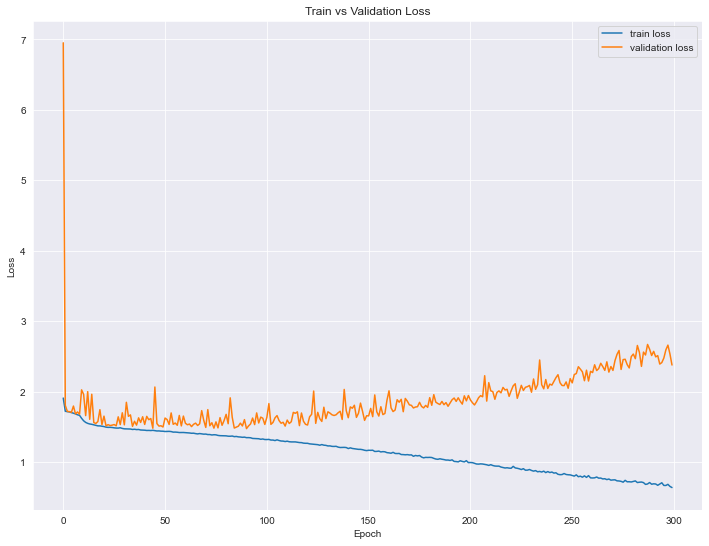

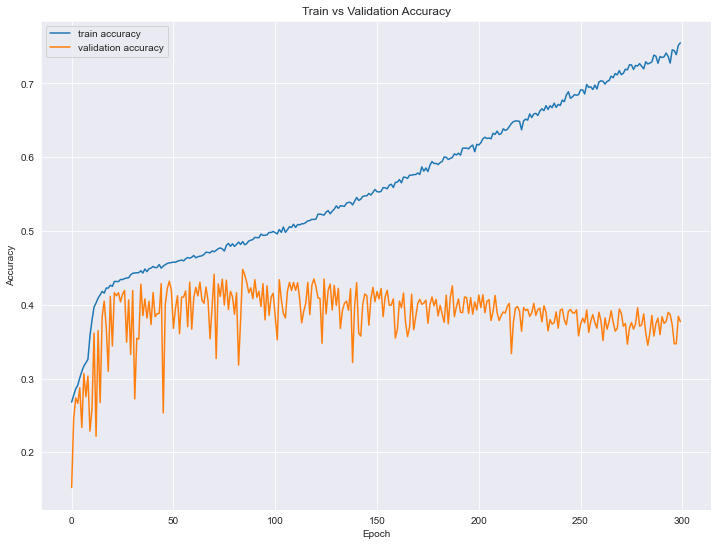

In [137]:
plot_loss_acc(model3_hist300, 300)

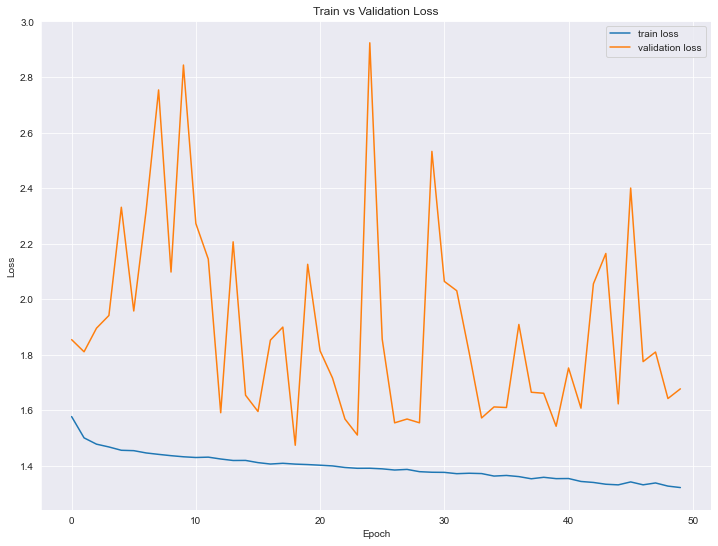

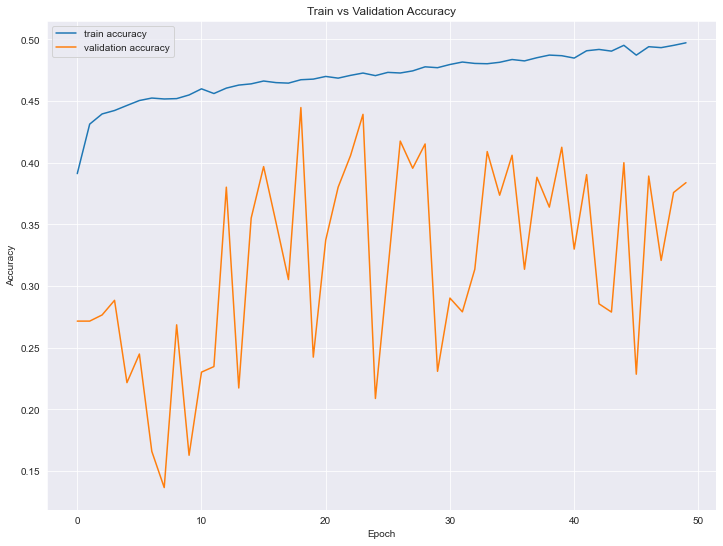

In [171]:
plot_loss_acc(model3_hist, 50)

235/235 [==============================] - 2s 7ms/step

=======================Evaluation on Train Set=======================

Accuracy on train set: 0.428

========================Evaluation on Test Set=======================

Accuracy on test set: 0.392
Cohen’s kappa coefficient on test set: 0.210

==================Classification Report on Test Set==================

                     precision    recall  f1-score   support

              pecan       0.39      0.46      0.42      2035
          elm cedar       0.37      0.73      0.49      1661
  southern live oak       0.48      0.39      0.43      1623
escarpment live oak       0.31      0.10      0.16      1105
       crape myrtle       0.26      0.03      0.05       467
          hackberry       0.18      0.01      0.02       372
       ashe juniper       0.25      0.07      0.11       229

           accuracy                           0.39      7492
          macro avg       0.32      0.26      0.24      7492
       weighted

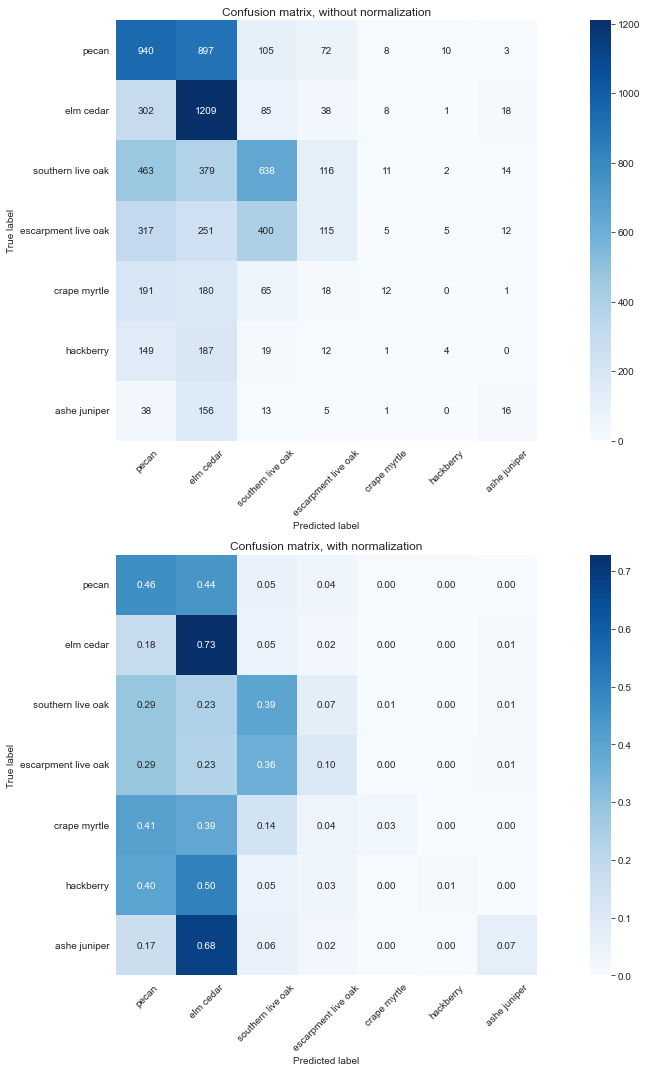

In [172]:
metrics_evaluation(X_train, X_test, y_train, y_test, res34_3, classes=tree_species)

In [174]:
X_pre = keras.applications.resnet50.preprocess_input(X)

In [176]:
X_pre.shape

(37458, 8, 8, 4)

In [178]:
X_pre_dev, X_pre_test, y_dev, y_test = train_test_split(X_pre, y, test_size=0.2, stratify = y, random_state=42)
X_pre_train, X_pre_val, y_train, y_val = train_test_split(X_pre_dev, y_dev, test_size=0.2, stratify = y_dev, random_state=42)

In [179]:
res34_4 = create_ResNet34()

In [181]:
model4_hist = res34_4.fit(x=X_pre_train, y=y_train_oh, 
                          batch_size=256,
                          epochs=50, 
                          validation_data=(X_pre_val, y_val_oh),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
94/94 [==============================] - 10s 106ms/step - loss: nan - accuracy: 0.2716 - val_loss: nan - val_accuracy: 0.2716
Epoch 2/50
94/94 [==============================] - 10s 107ms/step - loss: nan - accuracy: 0.2716 - val_loss: nan - val_accuracy: 0.2716
Epoch 3/50
94/94 [==============================] - 10s 107ms/step - loss: nan - accuracy: 0.2716 - val_loss: nan - val_accuracy: 0.2716
Epoch 4/50
94/94 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2716

KeyboardInterrupt: 